In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [3]:
def f_linear(m,b,x):
    """ Linear Function """
    return m*x+b
def f_parabola(a,b,c,x):
    """ parabola function """
    return  a*x**2.0 + b*x + c

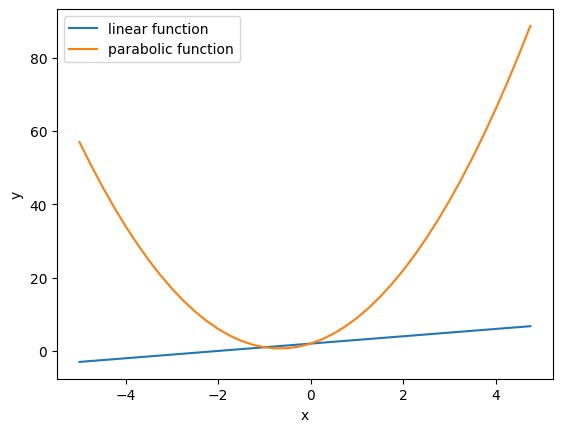

In [4]:
x = np.arange(-5,5,0.25)
yl = f_linear(1,2,x)
yp = f_parabola(3,4,2,x)
plt.plot(x,yl,label="linear function")
plt.plot(x,yp,label="parabolic function")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [5]:
h = 0.001
x = 3.0
f_parabola(3.0,4.0,2.0,x)

41.0

In [6]:
(f_parabola(3,4,2,x+h) -  f_parabola(3,4,2,x))/h

22.002999999997996

In [7]:
## more example
a = 2.0
b = -3.0
c = 10.0
h = 0.0001
d = a*b + c
da = (a+h)*b + c
db = a*(b+h) + c
dc = a*b + (c+h)

print("d : ",d)
print("da : ",da)
print("db : ",db)
print("dc : ",dc)

# slope
print("slope when a changes: ", (da - d)/h )
print("slope when b changes: ", (db - d)/h )
print("slope when c changes: ", (dc - d)/h )



d :  4.0
da :  3.999699999999999
db :  4.0002
dc :  4.0001
slope when a changes:  -3.000000000010772
slope when b changes:  2.0000000000042206
slope when c changes:  0.9999999999976694


# create core Value object

In [165]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self, other),"+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    
    def __neg__(self):
        return self * -1  
    def __sub__(self,other):
        return self + (-other)
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only support int and float in pow operation"
        out = Value(self.data**other,(self,),f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ),"tanh")
        def _backward():
            self.grad += (1 - t**2) / out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ),"exp")
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
    

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d, d._prev

(Value(data=4.0), {Value(data=-6.0), Value(data=10.0)})

## Visualization code

In [28]:

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    dot = Digraph(format="svg", graph_attr={'rankdir': "LR"}) #, node_attr={'rankdir': 'TB'})
    nodes, edges = trace(root)
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

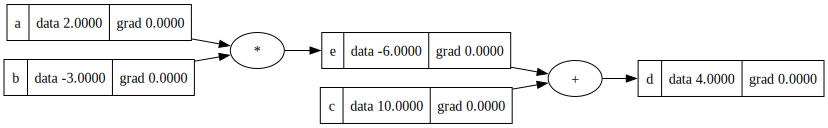

In [29]:
draw_dot(d)

## Back prop

In [94]:
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = 'o'

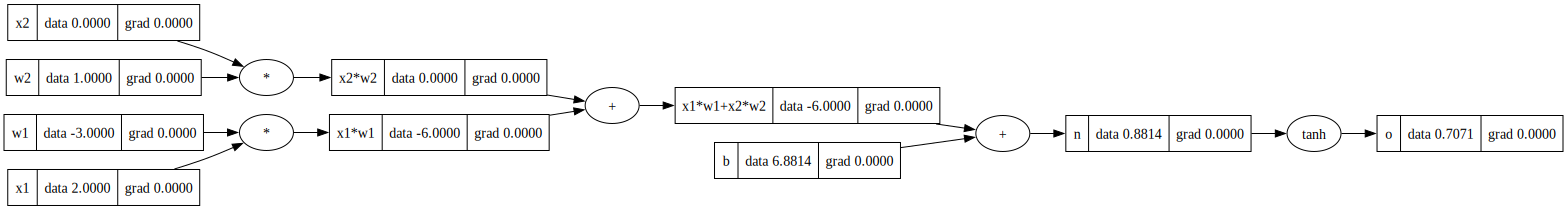

In [95]:
# before backprop
draw_dot(o)

In [96]:
# backpropogating
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

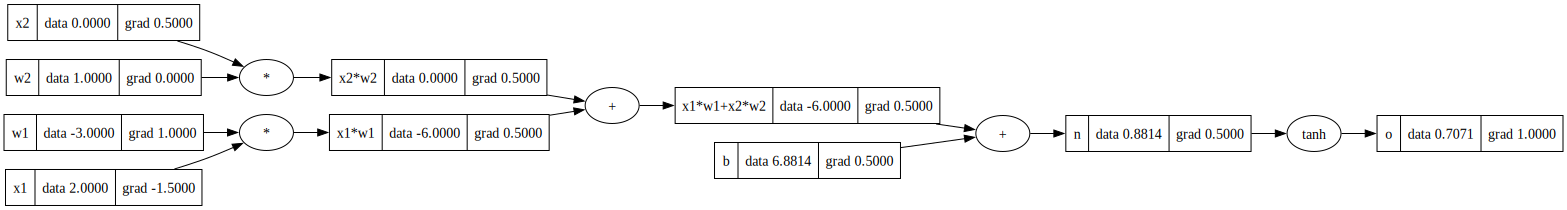

In [97]:
draw_dot(o)

In [98]:
## we can automate it
## add topological sort in backward function inside the Value
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = 'o'


o.backward()

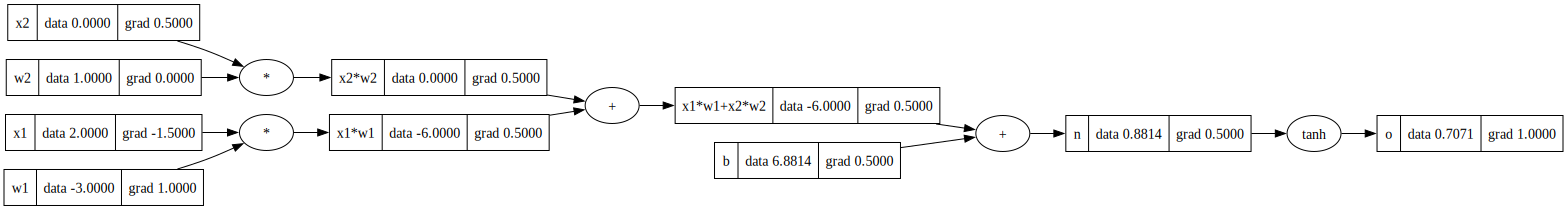

In [99]:
draw_dot(o)

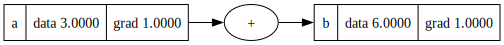

In [47]:
## multivariant bug issue
a = Value(3.0,label="a")
b = a + a; b.label="b"
b.backward()
draw_dot(b)
# the gradient is wrong
# """
# db/da = 1 + 1 = 2
# here the answer is 1

# so we need to accumilate the gradients
# """

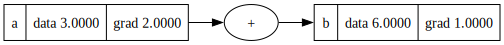

In [50]:
## after bug fixing
a = Value(3.0,label="a")
b = a + a; b.label="b"
b.backward()
draw_dot(b)

## test

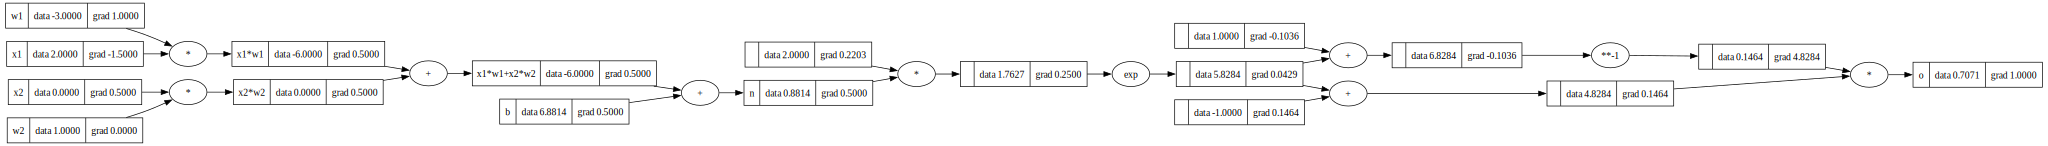

In [166]:
### breaking up tanh
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [167]:
import torch

In [168]:
# currosponding torch implementation
### breaking up tanh
x1 = torch.tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double() ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print("*"*50)
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())



0.7071066904050358
**************************************************
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [169]:
# 1:44:41 / 2:25:51
# building out a neural net library (multi-layer perceptron) in micrograd

